In [2]:
import torch
import torch.nn as nn
import torch.utils.data as data
import zuko

from torch import Tensor
from torch.distributions import Distribution, Normal, Bernoulli, Independent

from tqdm import tqdm

## Prep model

In [3]:
# create deconvolution ELBO 
class Deconvolution_ELBO(nn.Module):
    def __init__(
        self,
        encoder: zuko.flows.LazyDistribution,
        decoder: zuko.flows.LazyDistribution,
        prior: zuko.flows.LazyDistribution,
        likelihood : zuko.flows.LazyDistribution,
    ):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.prior = prior
        self.likelihood = likelihood
        

    def forward(self, x: Tensor) -> Tensor:
        
        # encode the input
        posterior_context = self.encoder(x).rsample()

        # decoder the input
        q = self.decoder(posterior_context)
        latant = q.rsample()
        log_q_z = q.log_prob(latant)
        
        # Compute log prob of latents under the prior.
        log_p_z = self.prior().log_prob(latant)
        
        

        # Compute log prob of the input under the model.
        log_p_x = self.likelihood(latant).log_prob(x)

        # Compute the ELBO as the sum of the log probs.
        elbo = log_p_x + log_p_z - log_q_z
        return elbo


        
    



        

In [4]:
class Deconv_ELBO_2(nn.Module):
    def __init__(
        self,
        encoder: zuko.flows.LazyDistribution,
        decoder: zuko.flows.LazyDistribution,
        prior: zuko.flows.LazyDistribution,
    ):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.prior = prior

    def forward(self, x: Tensor) -> Tensor:
        q = self.encoder(x)
        z = q.rsample()
        

      
        return self.decoder(z).log_prob(x) + self.prior(x).log_prob(z) - q.log_prob(z)

In [5]:
# decoder and encoder 
class GaussianModel(zuko.flows.LazyDistribution):
    def __init__(self, features: int, context: int):
        super().__init__()
        
        self.hyper = nn.Sequential(
            nn.Linear(context, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2 * features),
        )

    def forward(self, c: Tensor) -> Distribution:
        phi = self.hyper(c)
        
        mu, log_sigma = phi.chunk(2, dim=-1)

        return Independent(Normal(mu, log_sigma.exp()), 1)
    
 



In [6]:
# model 
def train_model(X_train,feature=2, context=60,batch_size=5,model = None ):
    
    trainloader = data.DataLoader(X_train, batch_size=batch_size, shuffle=True)
    elbo = model
    optimizer = torch.optim.Adam(elbo.parameters(), lr=1e-3)

    for epoch in (bar := tqdm(range(20))):
        losses = []

        for x in trainloader:
            
            
            loss = -elbo(x).mean()
            loss.backward()
            

            optimizer.step()
            optimizer.zero_grad()

            losses.append(loss.detach())

        losses = torch.stack(losses)

        bar.set_postfix(loss=losses.mean().item())
    return elbo.prior, elbo.encoder

## Test on diferent data 

In [7]:
means = torch.Tensor([
    [0.0, 0.0],
    [2, 3],
    [2, -3]
])
covars = torch.Tensor([
    [
        [0.1, 0],
        [0, 1.5]
    ],
    [
        [1, 0],
        [0, 0.1]
    ],
    [
        [1, 0],
        [0, 0.1]
    ]
])

Z = torch.distributions.MultivariateNormal(loc=means, covariance_matrix=covars).sample((100_000,)).reshape((-1, 2))

In [8]:
import matplotlib.pyplot as plt
idx = torch.randperm(Z.shape[0])
Z = Z[idx]
Z_train = Z[:Z.shape[0] // 2]
Z_test = Z[Z.shape[0] // 2:]

x_lim = (-2, 6)
y_lim = (-6, 6)



In [9]:
S = torch.Tensor([
    [0.1, 0],
    [0, 3]
])
X = Z + torch.distributions.MultivariateNormal(loc=torch.Tensor([0.0, 0.0]), covariance_matrix=S).sample((Z.shape[0],))
X_train = X[:X.shape[0] // 2]
X_test = X[X.shape[0] // 2:]




In [10]:
# Generate moons dataset
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=10000, noise=0.0)
X = torch.Tensor(X)


In [11]:


encoder = GaussianModel(25,2)
decoder = zuko.flows.NAF(
    features=2,
    context=25,
    transforms=3,
    hidden_features=(256, 256),
)

prior = zuko.flows.NAF(
    features=2,
    
    transforms=3,
    hidden_features=(256, 256),
)
likelihood = GaussianModel(2,2)


prior,encoder = train_model(X_train,feature=2, context=60,batch_size=256,model = Deconvolution_ELBO(encoder,decoder,prior,likelihood))

 65%|██████▌   | 13/20 [1:03:21<34:36, 296.70s/it, loss=4.15]

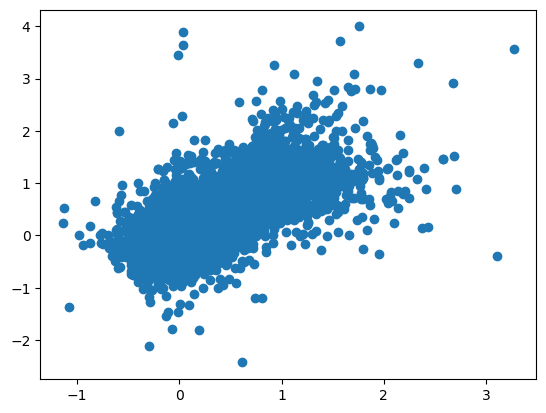

In [14]:
sample = prior().sample((10000,))
# plot the sample
plt.scatter(sample[:, 0].numpy(), sample[:, 1].numpy())

In [17]:
from nflows.nn.nets import ResidualNet

encoder = GaussianModel(
    features=2,
    context=2,
)
decoder = zuko.flows.NAF(
    features=2,
    context=2,
    transforms=3,
    hidden_features=(256, 256),
)

prior = zuko.flows.NAF(
    features=2,
    context=2,
    transforms=3,
    hidden_features=(256, 256),
)



prior,encoder = train_model(X,feature=2, context=60,batch_size=256,model = Deconv_ELBO_2(encoder,decoder,prior))

100%|██████████| 20/20 [02:41<00:00,  8.05s/it, loss=-3.35]


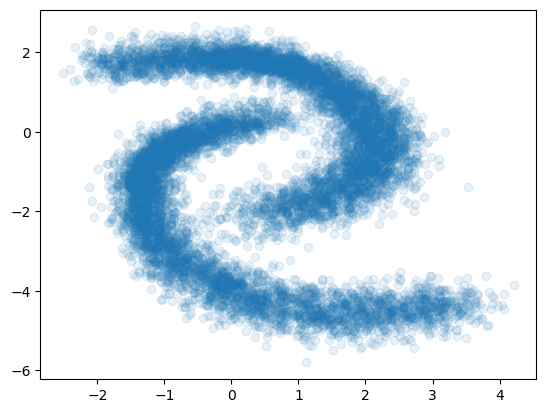

In [21]:
sample = prior(X).sample()

plt.scatter(sample[:, 0].numpy(), sample[:, 1].numpy(), alpha=0.1)
# p

In [20]:
X, y = make_moons(n_samples=10000, noise=0.1)
X = torch.Tensor(X)


In [ ]:
# plot moons data set
 
